# Mantid neutron data reduction demo

Welcome to the mantid neutron data demo! Please see the repo `readme` to see how to install mantid. 

In this tutorial, we will use the mantid framework to load, visualise and manipulate the neutron dataset you've downloaded from [dropbox](https://www.dropbox.com/scl/fo/kduv87wx4j2cc71u9lu97/AKy4Yn7Q_EAvXyd1jV0jd1w?rlkey=jcy7759n02vqc8ikwyglr5k30&st=rvf18jlv&dl=0).

In this notebook, mantid will be invoked using python scripting and some basic familiarity with python is assumed. 

To execute the content of one of the cells in the this notebook. Just select it and hit `shift-enter`!

# A note on Mantid Workbench

While this notebook runs the mantid library via python scripting, the mantid developers also maintain `Mantid Workbench` which provides more GUI-based interactivity. All of the mantid algorithms used below can be invoked via a GUI interface within workbench. This will be demonstrated during the hands-on part of this tutorial. 

Mantid workbench can be opened by activating the tutorial conda environment and then typing: 
```
workbench
```
in a terminal prompt.

# The Tutorial

## Step zero: Jupyter

This part of the tutorial is constructed as a jupyter notebook. If you are unfamiliar with jupyter, here are be basics commandments:

1. You can run the code content of a cell by selecting it and hitting `shift-enter`
2. It is important that all cells are run and that this is done in order from top-to-bottom of the notebook! 

## Step one: import mantid and some other useful tools

As with most python scripts, our script will begin with importing the modules we're going to use. Just select the cell below and hit `Shift-Enter` to run it.

**Important notes:**

1. Mantid is quite a large package and can be a little slow to load (on my machine, this took around 30s). If you see an asterisk next to the cell number, that means it is still working on executing.
2. If you see any errors at this stage, check your conda environment is activated!**

In [1]:
from mantid.simpleapi import *
import matplotlib.pyplot as plt
import numpy as np
%matplotlib ipympl

FrameworkManager-[Notice] Welcome to Mantid 6.10.0
FrameworkManager-[Notice] Please cite: http://dx.doi.org/10.1016/j.nima.2014.07.029 and this release: http://dx.doi.org/10.5286/Software/Mantid6.10
DownloadInstrument-[Notice] Downloading 33 files from the instrument repository
DownloadInstrument-[Notice] A new Facilities.xml file has been downloaded, this will take effect next time Mantid is started.


## Get the data

The next step is to obtain the data, available on [dropbox](https://www.dropbox.com/scl/fo/kduv87wx4j2cc71u9lu97/AKy4Yn7Q_EAvXyd1jV0jd1w?rlkey=jcy7759n02vqc8ikwyglr5k30&st=rvf18jlv&dl=0).

mantid needs to know where the data are stored, so we will create a python string pointing to the directory: where you chose to download the data to.

Nb: This should contain the complete path and, for some operating systems, exactly match the case. In my case, the data are stored in my Downloads folder on a mac, located at:  

```
/Users/66j/Downloads
```
So I will create the variable `dataPath` and set it equal to a string containing this location.

I also want to create a variable for the filename of my first dataset. I want to look at the silicon, which is: 

```
NIST_Silicon.nxs
```

I will create a variable called `dataFile` and set it equal to a string with this filename (I'll skip the extension, which I can add later). Lastly, I'll create a third variable `dataSet` that combines these two values to give the complete location of the data. 

In [20]:
dataPath = "/Users/malcolmguthrie/Downloads/IUCrDataTutorial" #edit this to match where you put your copy of the data
dataFile = "NIST_Silicon"
dataSet = f"{dataPath}/{dataFile}.nxs"
print(f"full path to data set is: {dataSet}")

full path to data set is: /Users/malcolmguthrie/Downloads/IUCrDataTutorial/NIST_Silicon.nxs


## Load the data into MANTID

I'm now ready to load my first dataset into mantid. I can do this with the mantid algorithm `LoadNexus`. This is a good opportunity to explain some common characteristics of the mantid python api. 

Algorithm names are always follow "CamelCase" i.e. there are no spaces and the first letter of each word is capitalised. Parameters are contained in parentheses following the algorithm name and are separated by a comma. Parameters also follow CamelCase. Each algorithm has extensive documentation including available parameters, what their type is (integer vs string vs Boolean), some parameters are mandatory, some are optional and many have default values defined. A complete list of algorithms and their docs can be found [here](https://docs.mantidproject.org/nightly/algorithms/categories/AlgorithmIndex.html)   

The algorithm `LoadNexus` only requires two parameters be defined:

In [5]:
LoadNexus(Filename=dataSet,
          OutputWorkspace='silicon')

LoadNexus-[Notice] LoadNexus started
InstrumentDefinitionParser-[Notice] Geometry cache is not available
InstrumentDefinitionParser-[Notice] Creating cache in /Users/malcolmguthrie/.mantid/instrument/geometryCache/SNAP3d4b8e63b81660bb69fa7a3969f9302ee3602c23.vtp
ISISRunLogs-[Warning] Cannot find period log. Logs will be not be filtered by current period
ISISRunLogs-[Warning] Cannot find periods log. Logs will be not be filtered by current period
LoadNexus-[Notice] LoadNexus successful, Duration 1.59 seconds


EventWorkspace
Title: Calib: NIST Silicon 3mm coll at 50mm u/stream
Histograms: 18432
Bins: 500
Histogram
X axis: Time-of-flight / microsecond
Y axis: Counts per microAmp.hour
Distribution: False
Instrument: SNAP (2018-May-01 to 2100-Jan-31)Instrument from: /Users/malcolmguthrie/Downloads/IUCrDataTutorial/NIST_Silicon.nxs

Run start: 2024-Aug-06 00:47:12
Run end:  2024-Aug-06 11:47:44

Events: 6584703 (weighted, no times)

This has created something called a `MANTID Event Workspace`. The header info tells you some useful information about the dataset.

The `EventWorkspace` contains many useful things: 

1. It contains the neutron event data. In this case, there are 6584703 events. (n.b. these are labelled as "weighted" because a compression algorithm has been run and they are labelled as "no times" as the arrival times of the events have been discarded. Both processes were done to reduce the size of the file)
2. It contains 18432 histograms, each containing 500 bins. These a histograms of the events, calculated for each of the 18432 pixels in this instrument. Since the X axis is "Time-of-flight" it means the histograms are calculated as a function of TOF (in $\mu s$.
3. It contains a complete mathematical description of the instrument. Including the spatial location of every pixel (based on an idealised default geometry)
4. It contains a large set of experimental logs. These contain information on many things including:
     * sample information
     * sample temperature, pressure logs
     * instrument configuration
     * many others

## Interacting with a mantid workspace

Using a python interface, it's possible to access the contents of the workspace using many methods. To do this, you need to first create a handle on the workspace, this is done by creating a variable and equating it to the workspace, which is contained in a list called `mtd`. In the cell below, I have created a handle called `ws` and set it equal to the workspace `silicon` that we just created 

In [6]:
ws = mtd['silicon']

You can see the available methods by entering the workspace handle, followed by a `.` into a notebook cell and then pressing tab. Below I've created some examples which the cell will print to screen:

In [7]:
print(f"Number of events: {ws.getNumberEvents()}")
print(f"Maximum time of flight: {ws.getTofMax()}")
print(f"Number of histograms; {ws.getNumberHistograms()}")

Number of events: 6584703
Maximum time of flight: 16666.400390625
Number of histograms; 18432


Note, since these are python methods (like a function), the method name should be followed by a set of parentheses. Some of these methods require arguments and, in this case, these will be specified in the parentheses. For example, the methods `readX` and `readY` will return the x-values and y-values for the histogram of data in a given pixel ID and so the pixel ID is required as an argument. Here, I look at the contents of pixel 1000:

In [8]:
id = 1000
x = ws.readX(id)
y = ws.readY(id)
print(f" I have an array of {len(x)} x-values and an array of {len(y)} y-values")
print(f" The x-array is one larger than the y-array because this is a histogram")

 I have an array of 501 x-values and an array of 500 y-values
 The x-array is one larger than the y-array because this is a histogram


Note also, that some methods, have their own methods and attributes. For example, we can find the units of the x-axis using:

In [9]:
xUnits = ws.getAxis(0).getUnit().unitID()
print(f" The units of the x-axis are: {xUnits}")

 The units of the x-axis are: TOF


## Inspect the data

Mantid workbench has a powerful interface that allows you to visualise the 3d location of the neutron instruments, to inspect individual spectra and has tools for useful operations such as grouping and masking individual pixels.

Here a screen shot from workbench, which gives an image that allows us to visualise how all 18432 pixels are arranged in space within the instrument: 

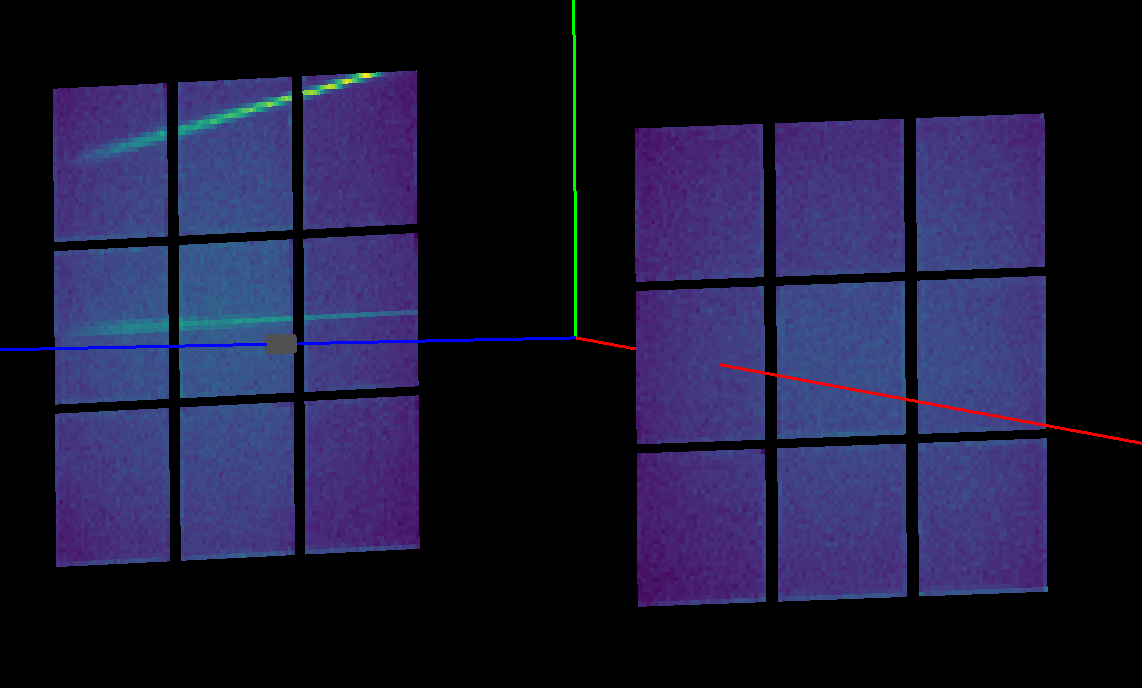

Here, the origin of the image is at the sample position, the green axis is vertical and the blue axis points paralle to the neutron beam. The instrument has two square detectors on opposite sides of the beam. Each detector is formed from 9 modules aligned in a 3x3 grid and each module has 32x32 pixels in it (32x32x9x2 = 18432).

The colour scale shows the total counts in each pixel. (Note that two gaps in the detector shielding led to the bright lines visible in the left-hand side detector!).


This screenshot is taken using a visualisation tool available in workbench. You can 

Now that we have a workspace holding our data, there are many mantid algorithms available that we can operate on it with. One of the first things we might want to do is convert the X-units from TOF to something more familiar, like d-spacing...

We can do this with a mantid algorithm called `ConvertUnits`:

In [10]:
ConvertUnits(InputWorkspace='silicon',
            OutputWorkspace='silicon',
            Target = 'dSpacing')

ConvertUnits-[Notice] ConvertUnits started
ConvertUnits-[Notice] ConvertUnits successful, Duration 0.09 seconds


EventWorkspace
Title: Calib: NIST Silicon 3mm coll at 50mm u/stream
Histograms: 18432
Bins: 500
Histogram
X axis: d-Spacing / Angstrom
Y axis: Counts per microAmp.hour
Distribution: False
Instrument: SNAP (2018-May-01 to 2100-Jan-31)Instrument from: /Users/malcolmguthrie/Downloads/IUCrDataTutorial/NIST_Silicon.nxs

Run start: 2024-Aug-06 00:47:12
Run end:  2024-Aug-06 11:47:44

Events: 6584703 (weighted, no times)

(Note: since I gave the output workspace the same name as the input, I have overwritten the original. This was deliberately done to minimise RAM usage: if I had used a different name, then I would have created a copy of the original workspace, doubling the memory requirement)

If I look at the properties of the workspace, I now see the units are in d-spacing.

Now I might want to inspect the histograms in individual pixels. `Mantid Workbench` has several very useful visualisation tools. But in this notebook, another way to do it is using matplotlib. We'll define a short python function to make this easy to do.  

In [11]:
def plotSpectrum(idList,workspaceName):

    #First we need to again define a handle pointing at the workspace.
    ws = mtd[workspaceName]
    #via this handle, we now have access to a large number of methods that can allow us to access the content of the workspace

    
    #now we create a figure and a set of axes
    fig, ax = plt.subplots()
    for id in idList:
        xHist = ws.readX(id)
        x = 0.5*(xHist[:-1]+xHist[1:])
        y = ws.readY(id)
        ax.plot(x,y,label=f'spectrum {id}')

    ax.set_label('Spectra')
    ax.set_xlabel(ws.getAxis(0).getUnit().unitID()) #note we're using the getAxis method to obtain the units
    ax.set_ylabel('normalised Intensity')
    ax.legend()

You might noticed, I set this up to iterate through a list of input spectra ID's. This lets me examine more than one spectra plotted together. I have 18432 spectra available. Here is what the first and last spectra look like: 

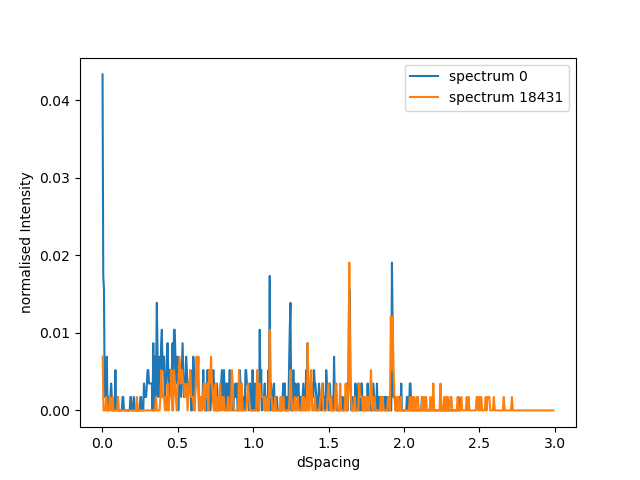

In [12]:
plotSpectrum([0,18431],'silicon')

This shows a rather unimpressive couple of spectra! The reason is that we're only plotting single pixels, which are very small, so don't have many counts.

**We need to add pixels together!!**

## Diffraction Focussing

The process of combining pixels is referred to as "diffraction focussing". This comes from analogy to focusing a lens: when the pixels are converted to d-spacing, any given Bragg peak always has the same value of d-spacing, so they line up or are "focussed".

On this particular instrument, we have a lot of flexibility on how to combine pixels. I could add all the pixels together into one single spectrum, but I am interested in looking at the angular dependence of the data. Mantid provides an easy way to define ways to group pixels based on the components of the detector via an algorithm called `CreateGroupingWorkspace`:   

In [13]:
CreateGroupingWorkspace(InputWorkspace='silicon', 
                        GroupDetectorsBy='Column', 
                        OutputWorkspace='SNAPColGp')

CreateGroupingWorkspace-[Notice] CreateGroupingWorkspace started
CreateGroupingWorkspace-[Notice] CreateGroupingWorkspace successful, Duration 0.09 seconds


CreateGroupingWorkspace_returns(OutputWorkspace=Title: 
Histograms: 18432
, NumberGroupedSpectraResult=18432, NumberGroupsResult=6)

Here I've defined groups according to the vertical columns of modules in each detector. This creates 6 pixel groups.

**Note: the group ID numbers increase as $2\theta$ decreases**

The next step is to combine these which is done with an algorithm called `DiffractionFocusing`:

In [14]:
DiffractionFocussing(InputWorkspace='silicon',
                     OutputWorkspace='silicon_column',
                     GroupingWorkspace='SNAPColGp')                     

DiffractionFocussing-[Notice] DiffractionFocussing started
DiffractionFocussing-[Notice] DiffractionFocussing successful, Duration 0.15 seconds


EventWorkspace
Title: Calib: NIST Silicon 3mm coll at 50mm u/stream
Histograms: 6
Bins: 500
Histogram
X axis: d-Spacing / Angstrom
Y axis: Counts per microAmp.hour
Distribution: False
Instrument: SNAP (2018-May-01 to 2100-Jan-31)Instrument from: /Users/malcolmguthrie/Downloads/IUCrDataTutorial/NIST_Silicon.nxs

Run start: 2024-Aug-06 00:47:12
Run end:  2024-Aug-06 11:47:44

Events: 6584703 (weighted, no times)

We how have a new workspace `silicon_column` that has 6 spectra. I want to use my function to plot all 6 of these together: 

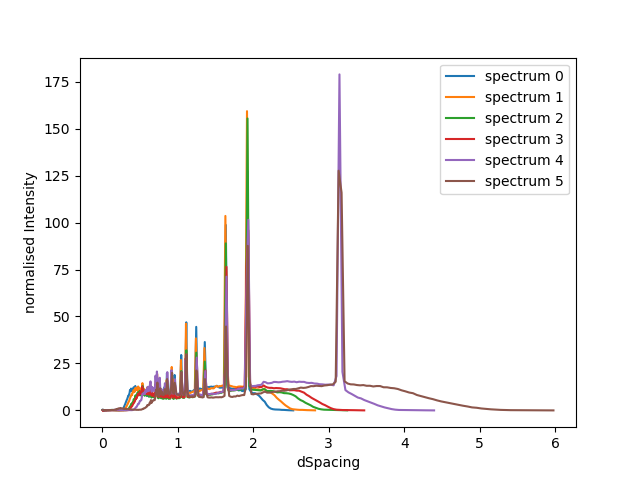

In [15]:
plotSpectrum([0,1,2,3,4,5],'silicon_column')

Now I have the correctly calibrated data, but if I zoom in, I can clearly see that they are horribly undersampled, with only one or two bins in each Bragg peak. This is because I still only have (a random default of) 500 equally-sized bins in my histograms. I want to resample my neutron events with a finer binning. Since the original event data are still contained in my workspace, all I have to do is rebin these.

Mantid has an algorithm `Rebin` to do this. This requires the definition of a minimum d-spacing (0.35 Å), a maximum d-spacing (4.7 Å) and a binning parameter that specifies the nature and number of bins. For time-of-flight, a convenient binning scheme is _logarithmic binning_ This generates data bins that are progressively larger at higher d-spacing to match the Bragg peak resolution and ensures approximately constant number of bins across each peak. With logarithmic binning, the x-value of the $n^{th}$ bin edge is given by:

$x_n = x_{n-1}(1+\Delta x)$

or, equivalently

$x_n = x_0(1+\Delta x)^n$

By convention, if a negative sign is used for the binning parameter in mantid, this indicates logarithmic binning with its absolute value giving $\Delta x$.  

Rebin-[Notice] Rebin started
Rebin-[Notice] Rebin successful, Duration 0.00 seconds


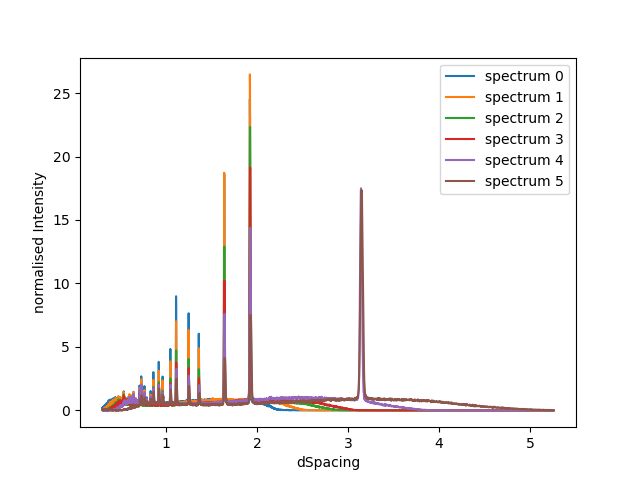

In [16]:
Rebin(InputWorkspace='silicon_column',
      OutputWorkspace='silicon_column',
      Params='0.3,-0.0008,5.26')

plotSpectrum([0,1,2,3,4,5],'silicon_column')

I can now see that my event data are better sampled. These plots already exhibit some of the properties of TOF detectors. The 2$\theta$ values of the columns decrease from low to high angle and we can see that: 

1. The maximum d-spacing increases towards low angle
2. The minimum d-spacing decreases towards high angle
3. The diffraction resolution (Bragg peak width) increases towards higher values.

But if we zoom in to, say the two peaks at 3.1 Å, we will see that they don't quite line up. Since these peaks correspond to the same Bragg reflection, they should have the same d-spacing. This is due to errors in the default mathematical description of the instrument used when calculating the conversion from TOF to d-spacing. To correct for this, we must apply a calibration. This calibration was already measured, and the calibration values (the "Diffractometer Constants") are stored in the provided file `diffract_consts.h5`. We need to convert our  *unfocussed* back to time-of-flight, apply the calibration and then convert to d-spacing again. Now, with the calibration applied, we can diffraction focus the data again.

ConvertUnits-[Notice] ConvertUnits started
ConvertUnits-[Notice] ConvertUnits successful, Duration 0.12 seconds
ApplyDiffCal-[Notice] ApplyDiffCal started
ApplyDiffCal-[Notice] ApplyDiffCal successful, Duration 0.10 seconds
ConvertUnits-[Notice] ConvertUnits started
ConvertUnits-[Notice] ConvertUnits successful, Duration 0.04 seconds
Rebin-[Notice] Rebin started
Rebin-[Notice] Rebin successful, Duration 0.01 seconds
DiffractionFocussing-[Notice] DiffractionFocussing started
DiffractionFocussing-[Notice] DiffractionFocussing successful, Duration 0.06 seconds


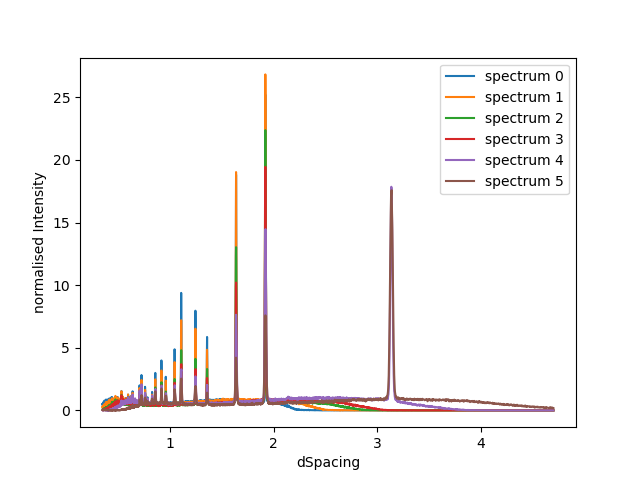

In [17]:
ConvertUnits(InputWorkspace='silicon',
             OutputWorkspace='silicon',
             Target='TOF')

ApplyDiffCal(InstrumentWorkspace='silicon', 
             CalibrationFile=f'{dataPath}/diffract_consts.h5')

ConvertUnits(InputWorkspace='silicon',
             OutputWorkspace='silicon',
             Target='dSpacing')

Rebin(InputWorkspace='silicon',
      OutputWorkspace='silicon',
      Params='0.35,-0.0008,4.7')

DiffractionFocussing(InputWorkspace='silicon',
                     OutputWorkspace='silicon_column',
                     GroupingWorkspace='SNAPColGp')

plotSpectrum([0,1,2,3,4,5],'silicon_column')

Once I'm sure that I'm happy with my binning, I can finally remove my event data, and only retain the histograms. This may be an important because the event data can consume a very large amount of memory and this quickly becomes a problem. To do this I can repeat the rebin operation, but now add an additional parameter `PreserveEvents` and set this to be `False`: 

In [18]:
Rebin(InputWorkspace='silicon_column',
      OutputWorkspace='silicon_column',
      Params='0.30,-0.0008,5.26',
      PreserveEvents=False)

Rebin-[Notice] Rebin started
Rebin-[Notice] Rebin successful, Duration 0.10 seconds


Workspace2D
Title: Calib: NIST Silicon 3mm coll at 50mm u/stream
Histograms: 6
Bins: 3582
Histogram
X axis: d-Spacing / Angstrom
Y axis: Counts per microAmp.hour
Distribution: False
Instrument: SNAP (2018-May-01 to 2100-Jan-31)Instrument from: /Users/malcolmguthrie/Downloads/IUCrDataTutorial/NIST_Silicon.nxs

Run start: 2024-Aug-06 00:47:12
Run end:  2024-Aug-06 11:47:44

It's important to be aware of what we've done. With the events deleted, any further changes in the histogram will be irreversible! On the plus side, our workspace has reduced in size from about 121 Mb to only 21 Mb (this makes a big difference if you have many datasets).

## Normalising the data

At this point, our data are almost ready to use, but we still need to normalise them for the wavelength response of the instrument. We will do this using our vanadium-niobium data. But to simplify our lives, we can gather all of the operations applied to our silicon data and just repeat them. Mantid does this conveniently as every workspace saves its own history. We can copy that history and use it to create a python script. I've done this below and then iterated through both my vanadium data and my empty data as I'll need both. Notice also, I added a step at the end to delete the original input data. This is again to save using too much memory. 

In [21]:
dataFiles = ['vanadium-niobium','empty']

for dataFile in dataFiles:

    dataSet = f"{dataPath}/{dataFile}.nxs"
    print(f"full path to data set is: {dataSet}")
    print(f"will create workspace called: {dataFile}")
    
    LoadNexus(Filename=dataSet, OutputWorkspace=dataFile)
    ConvertUnits(InputWorkspace=dataFile, OutputWorkspace=dataFile, Target='dSpacing')
    CreateGroupingWorkspace(InputWorkspace=dataFile, GroupDetectorsBy='Column', OutputWorkspace='SNAPColGp')
    ApplyDiffCal(InstrumentWorkspace=dataFile, CalibrationFile=f'{dataPath}/diffract_consts.h5')
    DiffractionFocussing(InputWorkspace=dataFile, OutputWorkspace=f'{dataFile}_column', GroupingWorkspace='SNAPColGp')
    Rebin(InputWorkspace=f'{dataFile}_column', OutputWorkspace=f'{dataFile}_column', Params='0.30,-0.0008,5.26', PreserveEvents=False)
    DeleteWorkspace(Workspace=dataFile)

full path to data set is: /Users/malcolmguthrie/Downloads/IUCrDataTutorial/vanadium-niobium.nxs
will create workspace called: vanadium-niobium
LoadNexus-[Notice] LoadNexus started
ISISRunLogs-[Warning] Cannot find period log. Logs will be not be filtered by current period
ISISRunLogs-[Warning] Cannot find periods log. Logs will be not be filtered by current period
LoadNexus-[Notice] LoadNexus successful, Duration 1.91 seconds
ConvertUnits-[Notice] ConvertUnits started
ConvertUnits-[Notice] ConvertUnits successful, Duration 0.12 seconds
CreateGroupingWorkspace-[Notice] CreateGroupingWorkspace started
CreateGroupingWorkspace-[Notice] CreateGroupingWorkspace successful, Duration 0.06 seconds
ApplyDiffCal-[Notice] ApplyDiffCal started
ApplyDiffCal-[Notice] ApplyDiffCal successful, Duration 0.11 seconds
DiffractionFocussing-[Notice] DiffractionFocussing started
DiffractionFocussing-[Notice] DiffractionFocussing successful, Duration 0.17 seconds
Rebin-[Notice] Rebin started
Rebin-[Notice] Re

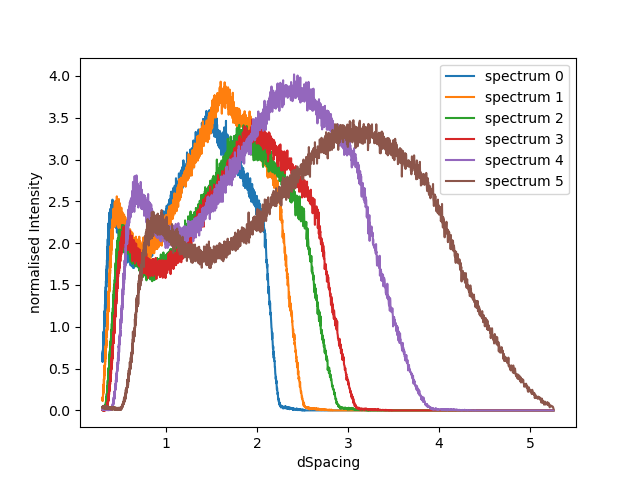

In [22]:
plotSpectrum([0,1,2,3,4,5],'vanadium-niobium_column')

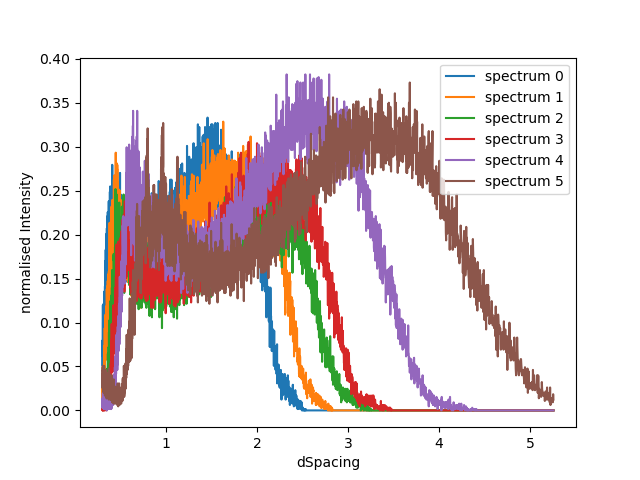

In [23]:
plotSpectrum([0,1,2,3,4,5],'empty_column')

The normalisation correction we need is captured in the vanadium-niobium scattering so we want to remove any other "background" contribution to that measurement. This is why we collected the "empty" instrument dataset, which should be identical to the vanadium-niobium measurement (e.g. same detector positions and same front end settings) only without the V-Nb. The vanadium-niobium signal we need is obtained by subtracting this empty:

Minus-[Notice] Minus started
Minus-[Notice] Minus successful, Duration 0.03 seconds


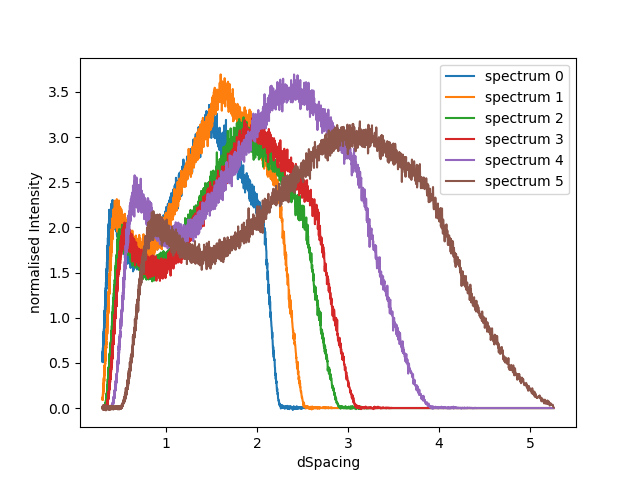

In [24]:
Minus(LHSWorkspace='vanadium-niobium_column',
      RHSWorkspace='empty_column',
      OutputWorkspace='norm_column')

plotSpectrum([0,1,2,3,4,5],'norm_column')

This gives me the raw data, but I want to do one further processing step, which is to smooth the data. I know that the normalisation correction is slowly varying in d-spacing, and smoothing will avoid adding unnecessary noise to my data. Again, I summon a mantid algorithm. It might be necessary to experiment to find the correct smoothing parameter `NPoints`. 

SmoothData-[Notice] SmoothData started
SmoothData-[Notice] SmoothData successful, Duration 0.01 seconds


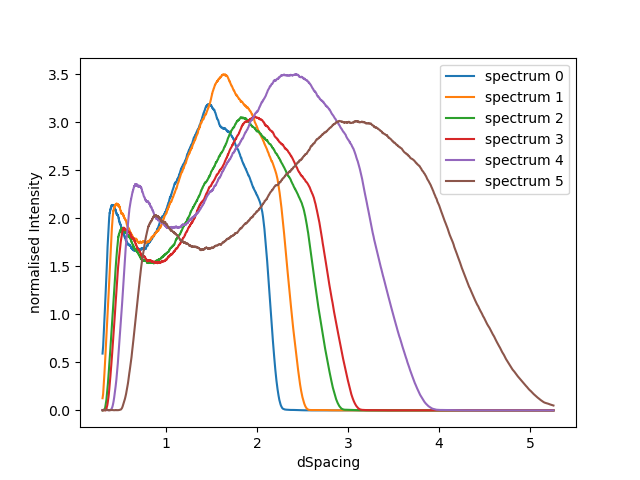

In [25]:
SmoothData(InputWorkspace='norm_column',
           OutputWorkspace='norm_column_smooth',
           NPoints = 50)
plotSpectrum([0,1,2,3,4,5],'norm_column_smooth')

## Final reduced data

Now I can apply this normalisation to obtain my reduced data. I will do this with a simple division

Divide-[Notice] Divide started
Divide-[Notice] Divide successful, Duration 0.09 seconds


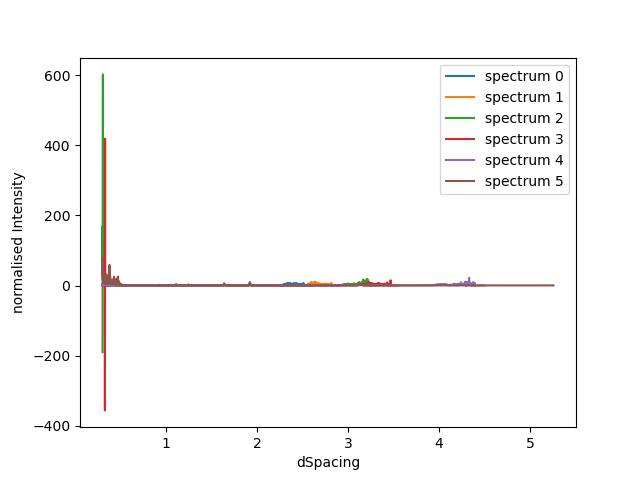

In [26]:
Divide(LHSWorkspace='silicon_column',
       RHSWorkspace='norm_column_smooth',
       OutputWorkspace='silicon_column_final')
plotSpectrum([0,1,2,3,4,5],'silicon_column_final')

Ugh! Why do my data look so bad!? 

This is because at the edge of each individual spectrum, the denominator `norm_column_smooth` becomes very small and the result of dividing becomes ill conditioned (and then NAN where the denominator is exactly zero). Since the d-spacing range is angle dependent, this happens at a different d-spacing for each spectrum. What I really need is custom binning parameters for each spectrum. These can be calculated for each spectrum and are tablulated here: 

|spectrum | average 2$\theta$ (deg) | d$_{min}$ (Å)| d$_{max}$ (Å)| d$_{bin}$ (Å)|
|---------|-------------------------|--------------|--------------|--------------|
|0| 150 |0.30 |2.22 |-0.0008 |
|1| 120 |0.33 |2.48 |-0.0008 |
|2| 110 |0.37 |2.86 |-0.0009 |
|3| 90  |0.39 |3.05 |-0.0009 |
|4| 60  |0.45 |3.86 |-0.0010 |
|5| 50  |0.55 |5.26 |-0.0012 |

Mantid has an algorithm `RebinRagged` that can be used to allow each spectrum to have its own binning parameters. Which are provided as a list:

In [27]:
RebinRagged(InputWorkspace='silicon_column_final',
            OutputWorkspace='silicon_column_final',
            XMin = [0.30,0.33,0.37,0.39,0.45,0.55],
            XMax = [2.22,2.48,2.86,3.05,3.86,5.26],
            Delta = [-0.0008,-0.0008,-0.009,-0.009,-0.001,0.0012])

RebinRagged-[Notice] RebinRagged started
RebinRagged-[Notice] RebinRagged successful, Duration 0.04 seconds


Workspace2D
Title: Calib: NIST Silicon 3mm coll at 50mm u/stream
Histograms: 6
Bins: variable
Histogram
X axis: d-Spacing / Angstrom
Y axis: Counts per microAmp.hour
Distribution: True
Instrument: SNAP (2018-May-01 to 2100-Jan-31)Instrument from: /Users/malcolmguthrie/Downloads/IUCrDataTutorial/NIST_Silicon.nxs

Run start: 2024-Aug-06 00:47:12
Run end:  2024-Aug-06 11:47:44

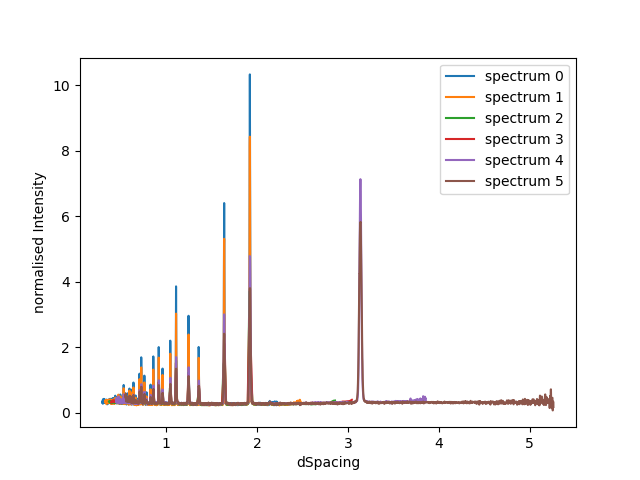

In [28]:
plotSpectrum([0,1,2,3,4,5],'silicon_column_final')

Congratulations! Now that your diffraction data are correctly calibrated, normalised and focussed, they are ready to export to a Rietveld package for analysis!